In [57]:
import math
import networkx as nx
import osmnx as ox
import pyrosm

In [45]:
G = ox.graph_from_place('Budapest', network_type='drive')

In [46]:
# geometry_hun = ox.geometries.geometries_from_place("Budapest", tags={'tourism': True})

In [47]:
# s = set()
# for x in geometry_hun["tourism"]:
#     s.add(x)
# s
# ezek lehetnek a tourism tag-hez rendelve

(528.5714285714286, geometry            POLYGON ((19.0507168 47.4688971, 19.0508368 47...
nodes               [4352623450, 5270852065, 5270852066, 526611167...
addr:city                                                    Budapest
addr:housenumber                                                   10
addr:postcode                                                    1117
addr:street                                     Prielle Kornélia utca
barrier                                                         fence
email                                                    info@mmkm.hu
facebook                   https://www.facebook.com/KozlekedesiMuzeum
fee                                                               yes
name                                             Műszaki Tanulmánytár
opening_hours       Oct 01-Apr 30 Tu-Fr 10:00-16:00, Oct 01-Apr 30...
operator                         Magyar Műszaki és Közlekedési Múzeum
phone                                                  +36 1 204 4095


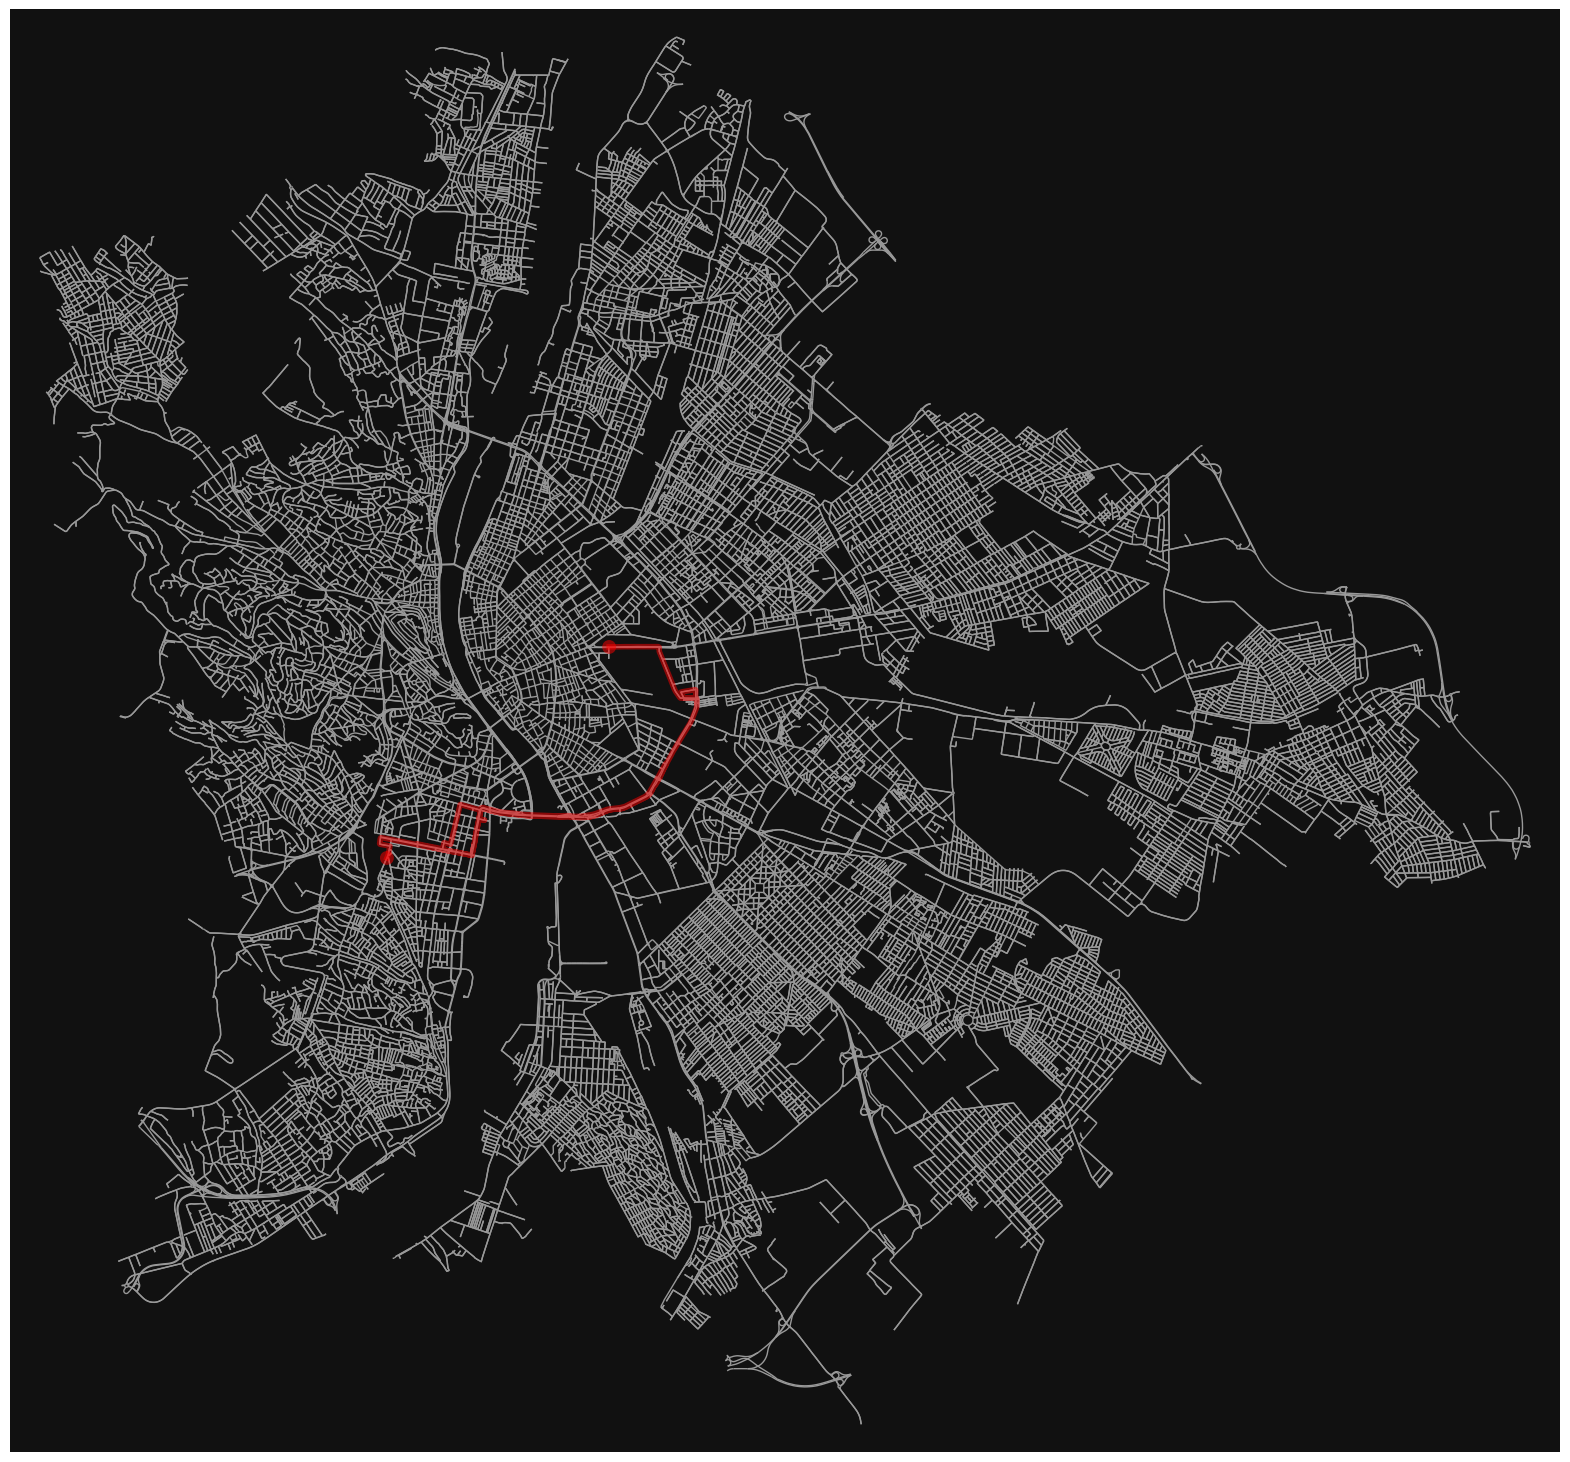

In [62]:
def heur_func(tourism_place, nearest_node, source_node, target_node):
    if tourism_place[1]['tourism'] in ['hotel', 'hostel', 'motel', 'information']:
        return -1
    try:
        path_length_from_source = nx.shortest_path_length(G, source_node, nearest_node)
        path_length_to_target = nx.shortest_path_length(G, nearest_node, target_node)
        score = 10000/(path_length_from_source + path_length_to_target)
        keys = tourism_place[1].keys()
        if   ('url' in keys and isinstance(tourism_place[1]['url'],str)) \
          or ('website' in keys and isinstance(tourism_place[1]['website'], str)):
            score = score + 100
        if 'phone' in tourism_place[1].keys() and isinstance(tourism_place[1]['phone'], str):
            score = score + 100
        if 'name' in tourism_place[1].keys() and isinstance(tourism_place[1]['name'], str):
            score = score + 150
        if 'artist_name' in tourism_place[1].keys() and isinstance(tourism_place[1]['artist_name'], str):
            score = score + 50
        return score
    except Exception as ex:
        print(str(ex))
        return -1

def get_tourism_route(source, target, max_dist=1000, max_tourism_places=5):
    source_node = ox.nearest_nodes(G, source[0], source[1])
    target_node = ox.nearest_nodes(G, target[0], target[1])
    route = nx.shortest_path(G, source_node, target_node)
    heuristic_values = {}
    
    # collect near tourist places
    for node in route:
        tourism_places = ox.geometries.geometries_from_point((G.nodes[node]['y'], G.nodes[node]['x']), tags={'tourism': True}, dist=max_dist)
        for tourism_place in tourism_places.iterrows():
            geometry = tourism_place[1].geometry
            x = geometry.centroid.x
            y = geometry.centroid.y
            nearest_node = ox.nearest_nodes(G, x, y)
            score = heur_func(tourism_place, nearest_node, source_node, target_node)
            if score > 0:
                heuristic_values[nearest_node] = (score, tourism_place[1])
    
    sorted_heuristic_values = {k: v for k, v in sorted(heuristic_values.items(), key=lambda item: item[1][0], reverse=True)}

    route = []
    # TODO: visit tourist places in their original order
    for i in range(min(max_tourism_places, len(sorted_heuristic_values))):
        tourism_target = list(sorted_heuristic_values.items())[i][0]
        route += nx.shortest_path(G, source_node, tourism_target)[:-1]
        source_node = tourism_target
        print(str(list(sorted_heuristic_values.items())[i][1]) + "\n\n")
    
    route += nx.shortest_path(G, source_node, target_node)
    ox.plot_graph_route(G, route, node_size=0, figsize=(20,20))
    return route

source = (19.022058, 47.461703) #(20.377699, 47.892877) #
target = (19.088286, 47.499008) #(20.369472, 47.925571) #

route = get_tourism_route(source, target, 100)

In [49]:
route

[3097782728,
 59768162,
 1811906090,
 1811906093,
 268732979,
 269163302,
 269163625,
 59768240,
 2052921652,
 263258025,
 59768247,
 223746850,
 435189038,
 59768256,
 152550350,
 256537955,
 256537844,
 41468928,
 154476503,
 268883048,
 154476505,
 154422835,
 268745520,
 3308156710,
 60760380,
 702000920,
 1654525673,
 1654525674,
 1654525677,
 215418507,
 280286566,
 280286547,
 41468870,
 59770457,
 685050576,
 6253622407,
 3307985635,
 41468944,
 154476505,
 154422835,
 1544888404,
 154422835,
 268745520,
 3308156710,
 60760380,
 84696038,
 305190128,
 1408226495,
 305187095,
 60760387,
 280336689,
 280336694,
 280336692,
 60760389,
 694096833,
 652910955,
 130591284,
 151015385,
 1418729903,
 1418729907,
 151015316,
 280186447,
 60760393,
 3309544898,
 110342082,
 60760394,
 365100657,
 1994276657,
 2678873635,
 683359755,
 1103805292,
 1105862988,
 280187764,
 101488262,
 280187760,
 3781632840,
 2619599977]